In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [18]:
# Load data
df = pd.read_csv('./dataset.csv')

# Prepare features and target
X = df.drop(columns=['COPDSEVERITY'])
y = df['COPDSEVERITY']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Handle missing values - fill with median for numeric columns
X = X.fillna(X.median(numeric_only=True))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [19]:
y_test

array([2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 3, 2, 0, 1, 1, 2, 0, 1, 3, 2, 1])

In [20]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_scaled

array([[ 1.31667736,  0.43116841, -0.38179255, ..., -0.37796447,
        -0.5       , -0.33333333],
       [-0.85836489, -0.14436228,  0.7090433 , ..., -0.37796447,
        -0.5       , -0.33333333],
       [-0.30597321, -0.98847397, -0.51814703, ..., -0.37796447,
        -0.5       ,  3.        ],
       ...,
       [-1.27265865,  1.4095706 , -0.10908358, ..., -0.37796447,
        -0.5       , -0.33333333],
       [ 1.4202508 ,  1.42875496, -0.38179255, ..., -0.37796447,
        -0.5       , -0.33333333],
       [ 0.00474712, -0.95010526,  0.0272709 , ...,  2.64575131,
        -0.5       , -0.33333333]], shape=(80, 23))

In [22]:

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)


In [23]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [24]:
# Define Neural Network with 2 hidden layers (halving dimensions)
input_dim = X_train.shape[1]
hidden1_dim = 23
hidden2_dim = 11
output_dim = len(np.unique(y_encoded))

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.fc3 = nn.Linear(hidden2_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [26]:
# Initialize model
model = NeuralNetwork(input_dim, hidden1_dim, hidden2_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Training
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

Epoch [20/300], Loss: 1.2425
Epoch [40/300], Loss: 1.0497
Epoch [60/300], Loss: 0.8032
Epoch [80/300], Loss: 0.6139
Epoch [100/300], Loss: 0.4741
Epoch [120/300], Loss: 0.3259
Epoch [140/300], Loss: 0.3916
Epoch [160/300], Loss: 0.2728
Epoch [180/300], Loss: 0.2863
Epoch [200/300], Loss: 0.2230
Epoch [220/300], Loss: 0.1778
Epoch [240/300], Loss: 0.1702
Epoch [260/300], Loss: 0.2524
Epoch [280/300], Loss: 0.0929
Epoch [300/300], Loss: 0.1324


In [28]:

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, predicted = torch.max(y_pred, 1)
    acc = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
    print(f'\nAccuracy: {acc:.4f}')



Accuracy: 0.7619


In [29]:

print(f'\nModel Architecture:')
print(f'Input Layer: {input_dim} neurons')
print(f'Hidden Layer 1: {hidden1_dim} neurons')
print(f'Hidden Layer 2: {hidden2_dim} neurons')
print(f'Output Layer: {output_dim} neurons')


Model Architecture:
Input Layer: 23 neurons
Hidden Layer 1: 23 neurons
Hidden Layer 2: 11 neurons
Output Layer: 4 neurons


In [30]:

print(f'\nModel Architecture:')
print(f'Input Layer: {input_dim} neurons')
print(f'Hidden Layer 1: {hidden1_dim} neurons')
print(f'Hidden Layer 2: {hidden2_dim} neurons')
print(f'Output Layer: {output_dim} neurons')

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'label_encoder': label_encoder,
    'input_dim': input_dim,
    'hidden1_dim': hidden1_dim,
    'hidden2_dim': hidden2_dim,
    'output_dim': output_dim
}, 'copd_model.pth')

print('\nModel saved as copd_model.pth')


Model Architecture:
Input Layer: 23 neurons
Hidden Layer 1: 23 neurons
Hidden Layer 2: 11 neurons
Output Layer: 4 neurons

Model saved as copd_model.pth


In [15]:
checkpoint = torch.load("copd_model.pth", weights_only=False)

input_dim     = checkpoint['input_dim']
hidden1_dim   = checkpoint['hidden1_dim']
hidden2_dim   = checkpoint['hidden2_dim']
output_dim    = checkpoint['output_dim']

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Move data to tensors
Xv = torch.tensor(X_test_tensor, dtype=torch.float32)
yv = torch.tensor(y_test_tensor, dtype=torch.long)

# Get predictions
with torch.no_grad():
    logits = model(Xv)
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()

y_true = yv.cpu().numpy()

# Compute loss (optional)
criterion = nn.CrossEntropyLoss()
val_loss = criterion(logits, yv).item()
val_acc = (y_pred == y_true).mean()

print("===== VALIDATION RESULTS =====")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}\n")

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

===== VALIDATION RESULTS =====
Validation Loss: 0.4348
Validation Accuracy: 0.7619

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5
           2       0.88      0.78      0.82         9
           3       0.33      0.50      0.40         2

    accuracy                           0.76        21
   macro avg       0.70      0.72      0.71        21
weighted avg       0.79      0.76      0.77        21



C:\Users\ASUS\AppData\Local\Temp\ipykernel_18612\4293056900.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xv = torch.tensor(X_test_tensor, dtype=torch.float32)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18612\4293056900.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yv = torch.tensor(y_test_tensor, dtype=torch.long)


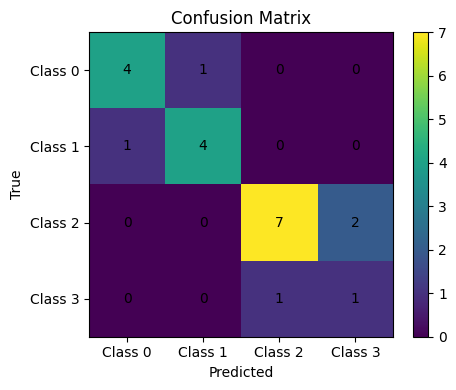

In [32]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(cm.shape[1]), [f"Class {i}" for i in range(cm.shape[1])])
plt.yticks(np.arange(cm.shape[0]), [f"Class {i}" for i in range(cm.shape[0])])
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()
